# Get all data

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import os
import time

In [2]:
def tau_convert(eigvals, avfr, T = 300, bar = None, HA = False):
    #kT in J
    avfr = avfr*1e-9
    kT = 1.38e-23*T
    #Convert to kg *nm^2 / ps^2
    sigma = (kT / avfr)
    #print(sigma)
    tau = 1e-6*eigvals*avfr /(kT)
    if bar == None:
        bar = np.zeros(len(eigvals))
    tau_scaled = tau*np.exp(bar)
    return tau

def get_rmsf_LE4PD(eigvec,eigval):
    rmsf = np.sqrt((eigval * (eigvec[::3,:]**2 + eigvec[1::3,:]**2 + eigvec[2::3,:]**2)).sum(1))
    return rmsf

def integ(y,x):
    integ_v=np.trapz(y,x)
    # f=interp1d(x,y,kind='cubic')
    # xval=np.linspace(x[0]+0.01, x[-1]-0.01,num=129,endpoint=True)
    # integ_v=simps(f(xval),xval)
    #print('Integration value : '+str(integ_v)+'\n')
    return integ_v

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install mdtraj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 25.7 MB/s eta 0:00:00


In [5]:
import mdtraj as md

In [6]:
# use values from universality paper

# scaling laws within error
a = 2.
gamma = 1.

# energy per unit length in kT / A
eps = (6.5 / 10.) / (1.38 * 0.3 * 6.022 *(1 / 4.184))

In [7]:
t_sim = np.linspace(0, 250000, 250001)
t_sim_10ns = np.linspace(0, 2500, 2501)
t_sim_100ns = np.linspace(0, 25000, 25001)
t_theo = np.linspace(0, 250000, 25001)

# 10 ps step for the theory
t = np.linspace(0, 250000, 25001)

In [8]:
data_prefix='/content/drive/MyDrive/AF2_dynamics/genML/'
ref_prefix='/content/drive/MyDrive/AF2_dynamics/CA_structs/'
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']
methods = ["BioEMU", "AFc", "DiG"]

data = {}

In [9]:
for i, sys in enumerate(sys_names):
  data[sys] = {}
  for j, meth in enumerate(methods):
    data[sys][meth] = {}
    data[sys][meth]['mu_eig'] = np.loadtxt(data_prefix + f"{sys}_{meth}/mu_eig")
    data[sys][meth]['lambda_eig'] = np.loadtxt(data_prefix + f"{sys}_{meth}/lambda_eig")
    data[sys][meth]['Q'] = np.load(data_prefix + f"{sys}_{meth}/Qmatrix.npy")
    data[sys][meth]['QINV'] = np.load(data_prefix + f"{sys}_{meth}/QINVmatrix.npy")
    data[sys][meth]['sigma'] = np.loadtxt(data_prefix + f"{sys}_{meth}/sigma")
    data[sys][meth]['avfr'] = np.loadtxt(data_prefix + f"{sys}_{meth}/avfr")

    tau = tau_convert(data[sys][meth]['lambda_eig'], data[sys][meth]['avfr'])
    tau_scaled = tau * np.exp((eps * np.sqrt(abs(data[sys][meth]['mu_eig']))))
    #tau_list.append(tau)
    #tau_scaled_list.append(tau_scaled)
    weights = np.zeros((data[sys][meth]['Q'].shape[0] // 3, data[sys][meth]['Q'].shape[1]))
    for n, _ in enumerate(range(0, data[sys][meth]['Q'].shape[0], 3)):
        for a in range(data[sys][meth]['Q'].shape[1]):
            #print(a, counter)
            weights[n,a] = (data[sys][meth]['Q'][_:_+3,a]**2).sum(0) * data[sys][meth]['mu_eig'][a]
    #t = np.linspace(0, 100000, 100000)
    #corr_func = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau[None,:-6]))).T).T
    corr_func_scaled = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau_scaled[None,:-6]))).T).T
    #corr_func = corr_func / corr_func[0,:]
    corr_func_scaled = corr_func_scaled / corr_func_scaled[0,:]
    #corr_func_list.append(corr_func)
    data[sys][meth]['tcf'] = corr_func_scaled
    #cdf_list.append(1. - corr_func)
    data[sys][meth]['cdf'] = (1. - corr_func_scaled)
    data[sys][meth]['rmsf'] = get_rmsf_LE4PD(data[sys][meth]['Q'], data[sys][meth]['mu_eig'])
    data[sys][meth]['tau_avg'] = np.zeros(data[sys][meth]['Q'].shape[0] // 3)
    for i in range(data[sys][meth]['Q'].shape[0] // 3):
      data[sys][meth]['tau_avg'][i] = integ(corr_func_scaled[:,i], t)

/tmp/ipython-input-3460213108.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


In [10]:
# no deepfakes
nodeepfake_data = {}
for i, sys in enumerate(sys_names):
  nodeepfake_data[sys] = {}
  for j, meth in enumerate(methods):
    nodeepfake_data[sys][meth] = {}
    nodeepfake_data[sys][meth]['mu_eig'] = np.loadtxt(data_prefix + f"nodeepfakes_{sys}_{meth}/mu_eig")
    nodeepfake_data[sys][meth]['lambda_eig'] = np.loadtxt(data_prefix + f"nodeepfakes_{sys}_{meth}/lambda_eig")
    nodeepfake_data[sys][meth]['Q'] = np.load(data_prefix + f"nodeepfakes_{sys}_{meth}/Qmatrix.npy")
    nodeepfake_data[sys][meth]['QINV'] = np.load(data_prefix + f"nodeepfakes_{sys}_{meth}/QINVmatrix.npy")
    nodeepfake_data[sys][meth]['sigma'] = np.loadtxt(data_prefix + f"nodeepfakes_{sys}_{meth}/sigma")
    nodeepfake_data[sys][meth]['avfr'] = np.loadtxt(data_prefix + f"nodeepfakes_{sys}_{meth}/avfr")

    tau = tau_convert(nodeepfake_data[sys][meth]['lambda_eig'], nodeepfake_data[sys][meth]['avfr'])
    tau_scaled = tau * np.exp((eps * np.sqrt(abs(nodeepfake_data[sys][meth]['mu_eig']))))
    #tau_list.append(tau)
    #tau_scaled_list.append(tau_scaled)
    weights = np.zeros((nodeepfake_data[sys][meth]['Q'].shape[0] // 3, nodeepfake_data[sys][meth]['Q'].shape[1]))
    for n, _ in enumerate(range(0, nodeepfake_data[sys][meth]['Q'].shape[0], 3)):
        for a in range(nodeepfake_data[sys][meth]['Q'].shape[1]):
            #print(a, counter)
            weights[n,a] = (nodeepfake_data[sys][meth]['Q'][_:_+3,a]**2).sum(0) * nodeepfake_data[sys][meth]['mu_eig'][a]
    #t = np.linspace(0, 100000, 100000)
    #corr_func = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau[None,:-6]))).T).T
    corr_func_scaled = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau_scaled[None,:-6]))).T).T
    #corr_func = corr_func / corr_func[0,:]
    corr_func_scaled = corr_func_scaled / corr_func_scaled[0,:]
    #corr_func_list.append(corr_func)
    nodeepfake_data[sys][meth]['tcf'] = corr_func_scaled
    #cdf_list.append(1. - corr_func)
    nodeepfake_data[sys][meth]['cdf'] = (1. - corr_func_scaled)
    nodeepfake_data[sys][meth]['rmsf'] = get_rmsf_LE4PD(nodeepfake_data[sys][meth]['Q'], nodeepfake_data[sys][meth]['mu_eig'])
    nodeepfake_data[sys][meth]['tau_avg'] = np.zeros(data[sys][meth]['Q'].shape[0] // 3)
    for i in range(nodeepfake_data[sys][meth]['Q'].shape[0] // 3):
      nodeepfake_data[sys][meth]['tau_avg'][i] = integ(corr_func_scaled[:,i], t)

/tmp/ipython-input-3460213108.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


In [11]:
# import the MD ensembles as reference
data_prefix='/content/drive/MyDrive/AF2_dynamics/calculated_data/'

with open(f'{data_prefix}RMSF_mdtraj.pkl','rb') as g:
    RMSF=pickle.load(g)

with open(f'{data_prefix}RMSF_eric.pkl','rb') as g:
    RMSF_eric=pickle.load(g)

In [12]:
RMSF = RMSF_eric | RMSF

Text(0, 0.5, 'RMSF')

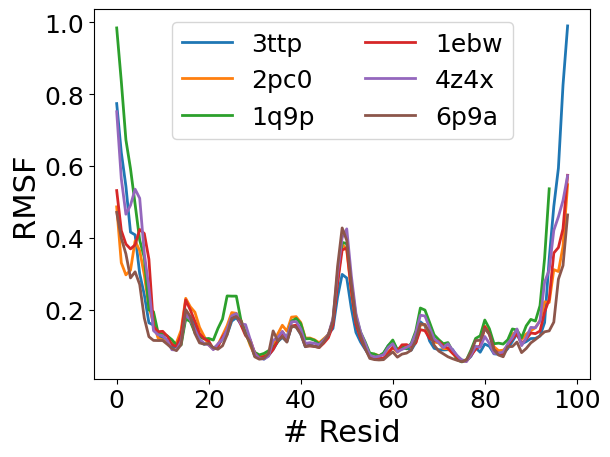

In [13]:
for sys in RMSF.keys():
    plt.plot(RMSF[sys]['MD']['RMSF'],linewidth=2,label=sys)
plt.legend(fontsize=18, ncols = 2);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.xlabel('# Resid',fontsize=22)
plt.ylabel('RMSF',fontsize=22)

# Plots required for fig5

In [35]:
ticksize=8
markersize=1.2
labelsize=12

BioEMU


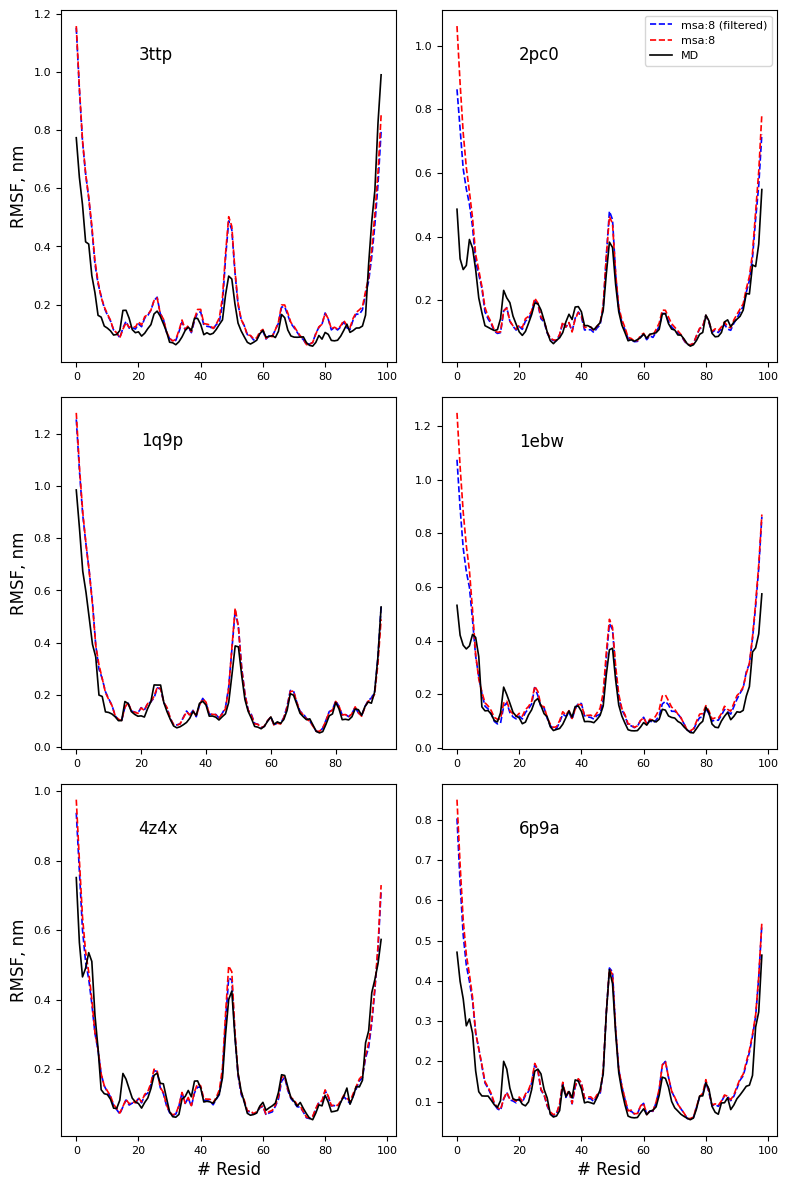

AFc


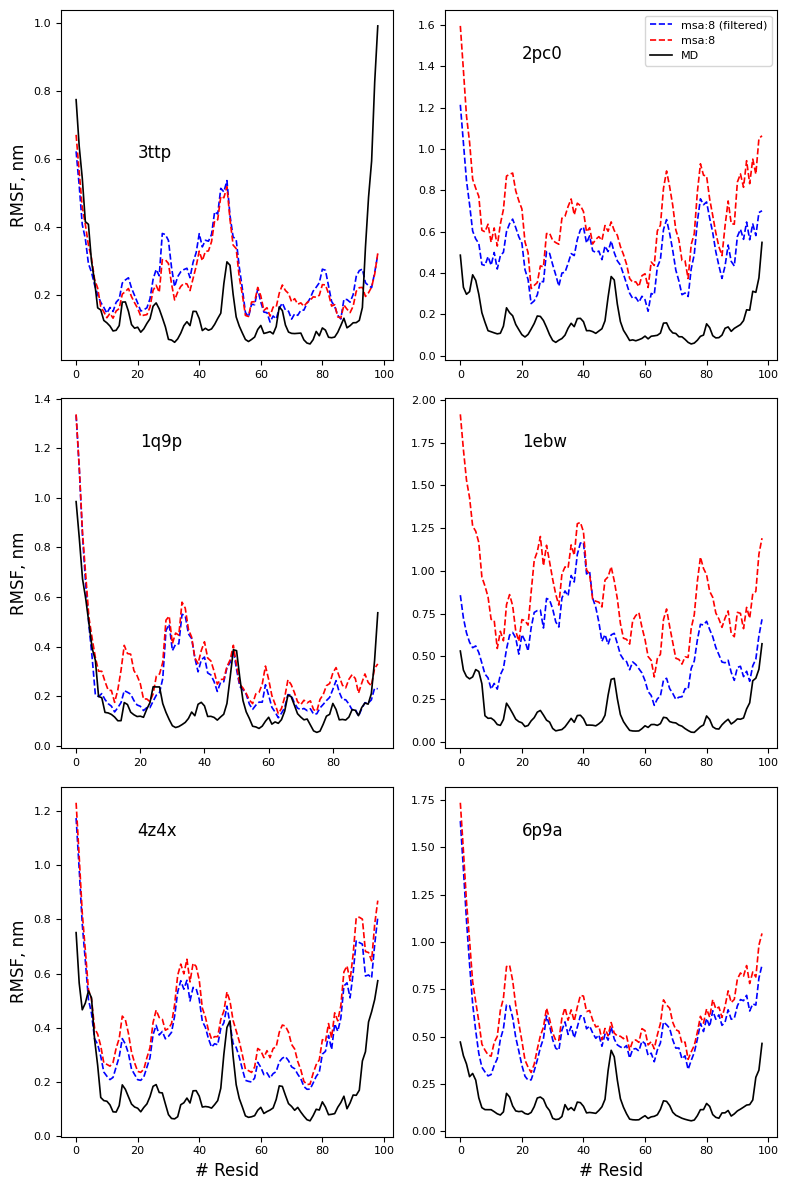

DiG


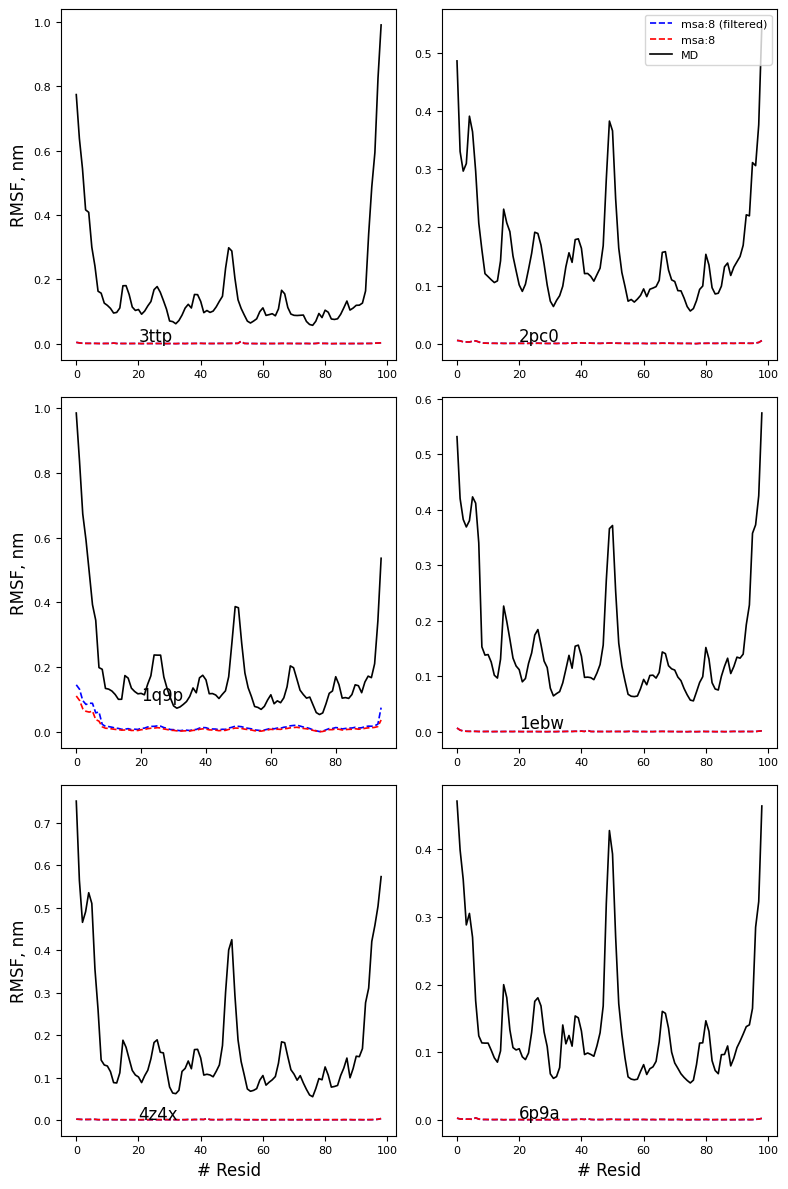

In [36]:
data_prefix='/content/drive/MyDrive/AF2_dynamics/'
msa=8
for jj, meth in enumerate(methods):
  print(meth)
  plt.figure(figsize=(8,12))
  for ii,SYS in enumerate(sys_names):
    plt.subplot(3,2,ii+1)
    plt.plot(nodeepfake_data[SYS][meth]['rmsf'],'--b',linewidth=markersize,label=f"msa:{msa} (filtered)")
    plt.plot(data[SYS][meth]['rmsf'],'--r',linewidth=markersize,label=f"msa:{msa}")

    plt.plot(RMSF[SYS]['MD']['RMSF'],'-k',linewidth=markersize,label=f"MD")
    #if meth == 'BioEMU':
    plt.text(x=20,y=0.9 * data[SYS][meth]['rmsf'].max(),s=f"{SYS}",fontsize=labelsize)
    #elif meth == 'AFc':
    #  plt.text(x=20,y=0.9,s=f"{SYS}",fontsize=labelsize)
    plt.xticks(fontsize=ticksize);
    plt.yticks(fontsize=ticksize);
    if (ii == len(sys_names) - 2) or (ii == (len(sys_names) - 1)):
      plt.xlabel('# Resid',fontsize=labelsize)
    if (ii % 2 == 0):
      plt.ylabel('RMSF, nm',fontsize=labelsize)
    if ii ==1:
      plt.legend(loc='upper right',fontsize=ticksize);
  plt.subplots_adjust(hspace=0.2,wspace=0.2)
  plt.savefig(data_prefix + f'figures/rmsf_comp_{meth}.png', dpi = 600)
  plt.tight_layout()
  plt.show()
  plt.close()


/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


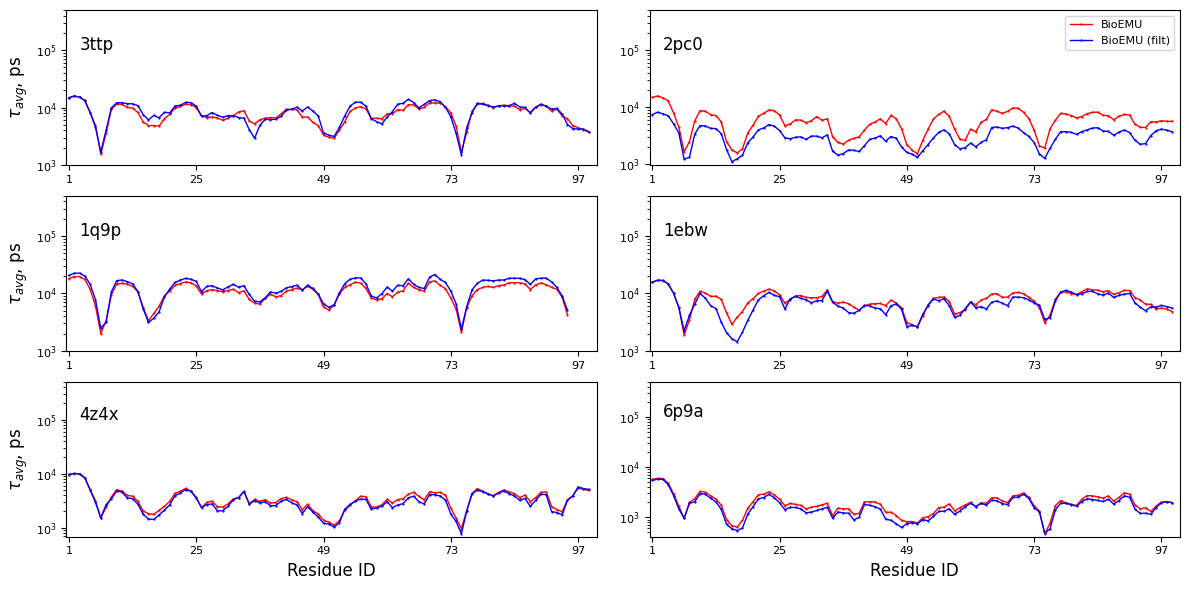

/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


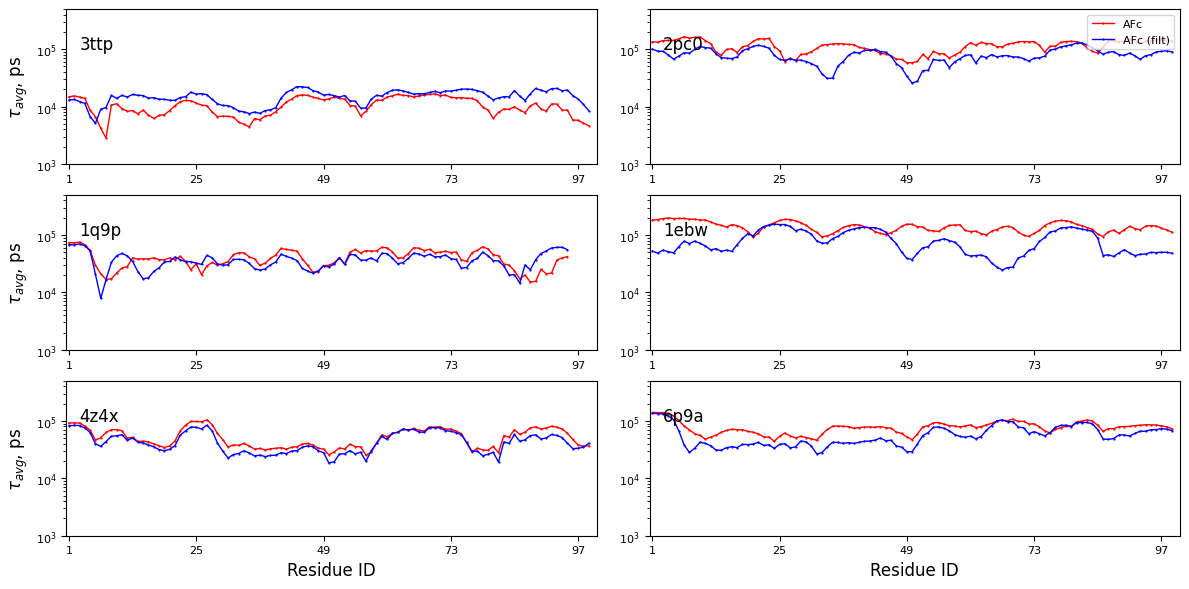

/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-1994769538.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


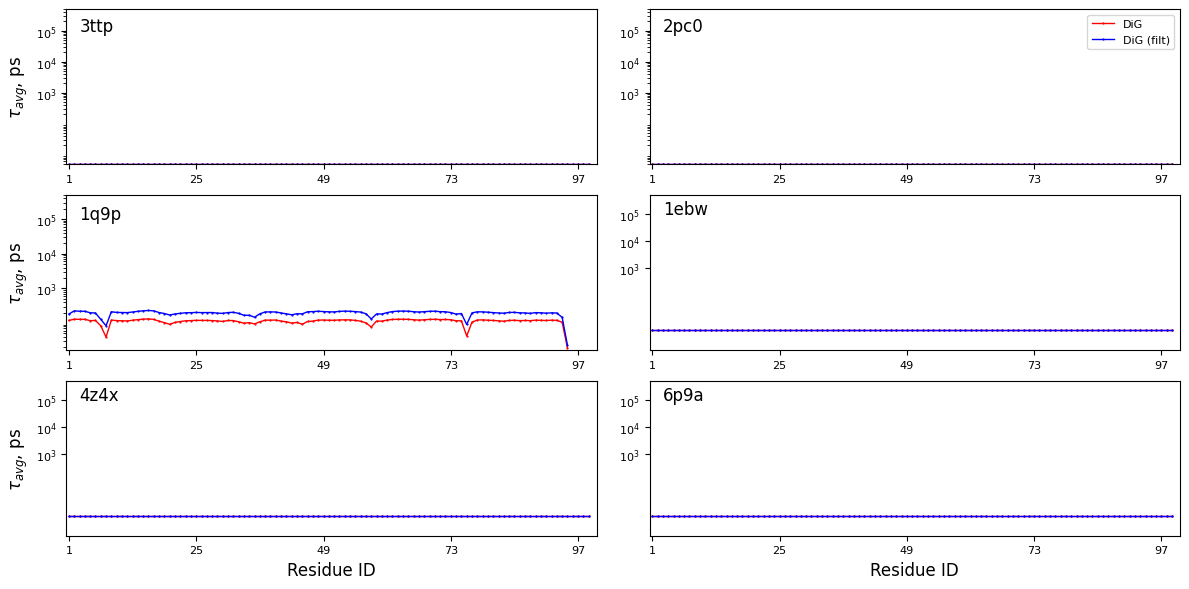

In [38]:
for jj, meth in enumerate(methods):
  plt.figure(figsize=(12,6))
  msa=8
  for ii,SYS in enumerate(sys_names):
    plt.subplot(3,2,ii+1)
    plt.plot(data[SYS][meth]['tau_avg'],'.-',c='r',linewidth=1,markersize=markersize,label=f'{meth}');
    plt.plot(nodeepfake_data[SYS][meth]['tau_avg'],'.-',c='b',linewidth=1,markersize=markersize,label=f'{meth} (filt)');
    # plt.plot(avg_tau_md[SYS]['1000ns'],'-k',linewidth=markersize,label=f"MD");
    plt.text(x=2,y=1e5,s=f"{SYS}",fontsize=labelsize);
    plt.yscale('log');
    plt.xlim(-0.5,99.5);
    plt.xticks(np.arange(0,99,24),labels=[str(r) for r in range(1,100,24)],fontsize=ticksize);
    if ii>=4:
      plt.xlabel('Residue ID',fontsize=labelsize);
    if ii%2==0:
      plt.ylabel(r'$\tau_{avg}$, ps',fontsize=labelsize);
    plt.ylim((0, 5e5));
    plt.yticks([1e3,1e4,1e5],fontsize=ticksize);
    plt.tight_layout();
    if ii ==1:
      plt.legend(loc='upper right',fontsize=ticksize);
  plt.subplots_adjust(hspace=0.2,wspace=0.1)
  plt.savefig(data_prefix + f'figures/tau_avg_comp_{meth}.png', dpi = 600)
  plt.show()
  plt.close()

/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));
/tmp/ipython-input-37-2450571807.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


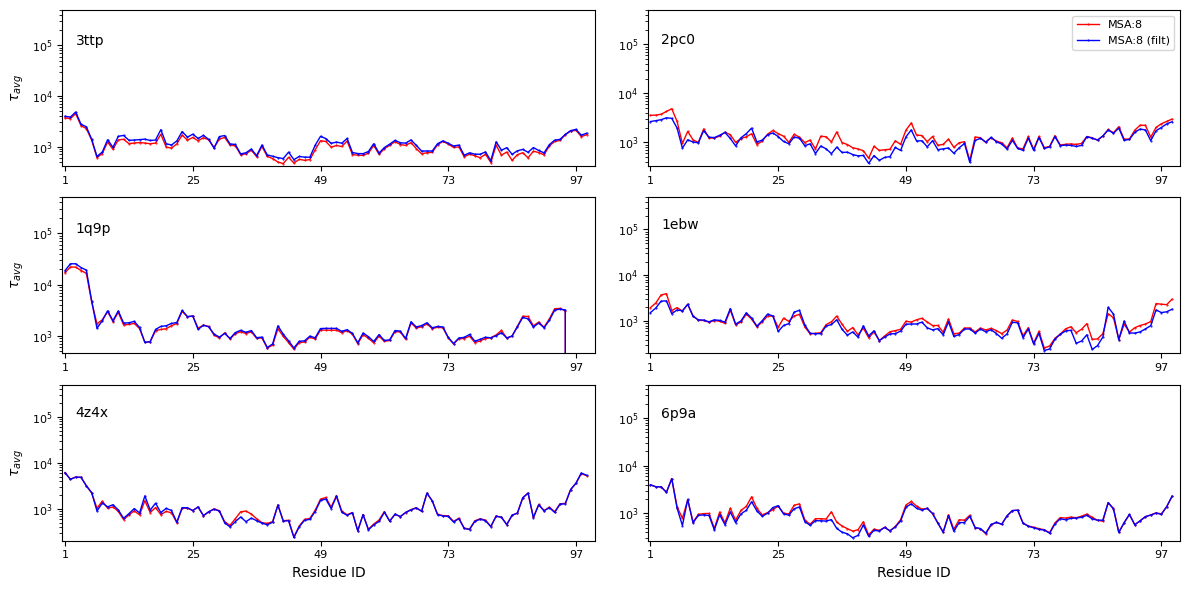

In [ ]:
# after MD cutoff

plt.figure(figsize=(12,6))
msa=8
for ii,SYS in enumerate(sys_names):
  plt.subplot(3,2,ii+1)
  plt.plot(Object_figure_5[SYS]['raw']['tau_mdcut'][0,:],'.-',c='r',linewidth=1,markersize=markersize,label=f'MSA:{msa}');
  plt.plot(Object_figure_5[SYS]['filtered']['tau_mdcut'][0,:],'.-',c='b',linewidth=1,markersize=markersize,label=f'MSA:{msa} (filt)');
  # plt.plot(avg_tau_md[SYS]['1000ns'],'-k',linewidth=markersize,label=f"MD");
  plt.text(x=2,y=1e5,s=f"{SYS}",fontsize=labelsize);
  plt.yscale('log');
  plt.xlim(-0.5,99.5);
  plt.xticks(np.arange(0,99,24),labels=[str(r) for r in range(1,100,24)],fontsize=ticksize);
  if ii>=4:
    plt.xlabel('Residue ID',fontsize=labelsize);
  if ii%2==0:
    plt.ylabel(r'$\tau_{avg}$',fontsize=labelsize);
  plt.ylim((0, 5e5));
  plt.yticks([1e3,1e4,1e5],fontsize=ticksize);
  plt.tight_layout();
  if ii ==1:
    plt.legend(loc='upper right',fontsize=ticksize);
plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.show()
plt.close()

/tmp/ipython-input-38-263070462.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


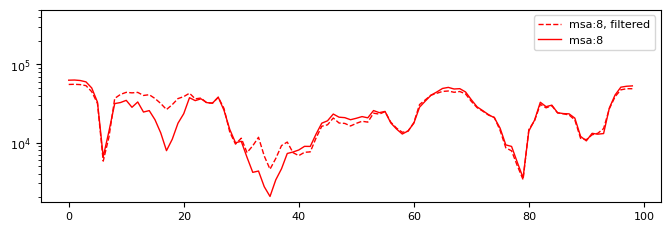

In [ ]:
plt.figure(figsize=(8,2.5))
for ii,SYS in enumerate(sys_names):
  if SYS=='4z4x':
    plt.plot(Object_figure_5[SYS]['filtered']['tau'][0,:],'--r',linewidth=markersize,label=f"msa:8, filtered")
    plt.plot(Object_figure_5[SYS]['raw']['tau'][0,:],'-r',linewidth=markersize,label=f"msa:8")
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);
plt.yscale('log')
# plt.xlabel('# Resid',fontsize=labelsize)
# plt.ylabel('RMSF',fontsize=labelsize)
plt.ylim((0, 5e5));
plt.legend(loc='upper right',fontsize=ticksize);
plt.show()


/tmp/ipython-input-39-3820473664.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 5e5));


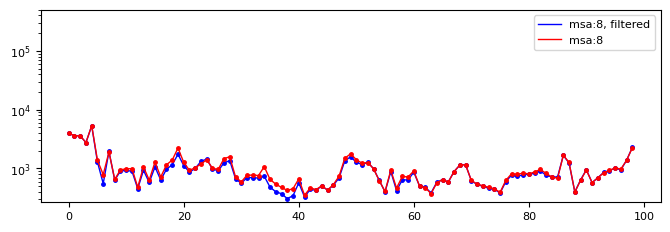

In [ ]:
plt.figure(figsize=(8,2.5))
for ii,SYS in enumerate(sys_names):
  if SYS=='6p9a':
    plt.plot(Object_figure_5[SYS]['filtered']['tau_mdcut'][0,:],'-b',linewidth=markersize,label=f"msa:8, filtered")
    plt.plot(Object_figure_5[SYS]['filtered']['tau_mdcut'][0,:],'.b',markersize=5)
    plt.plot(Object_figure_5[SYS]['raw']['tau_mdcut'][0,:],'-r',linewidth=markersize,label=f"msa:8")
    plt.plot(Object_figure_5[SYS]['raw']['tau_mdcut'][0,:],'.r',markersize=5)
    # plt.plot(avg_tau_md[SYS]['1000ns'],'-k',linewidth=markersize,label=f"MD")
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);
plt.yscale('log')
plt.ylim((0, 5e5));
plt.legend(loc='upper right',fontsize=ticksize);
plt.show()


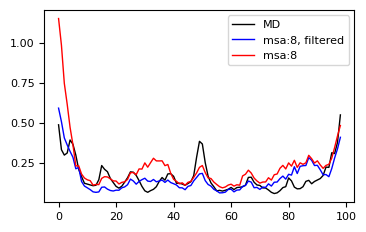

In [ ]:
plt.figure(figsize=(4,2.5))
for ii,SYS in enumerate(sys_names):
  if SYS=='2pc0':
    plt.plot(RMSF[SYS]['MD']['RMSF'],'-k',linewidth=markersize,label=f"MD")
    plt.plot(Object_figure_5[SYS]['filtered']['RMSF'],'-b',linewidth=markersize,label=f"msa:8, filtered")
    plt.plot(Object_figure_5[SYS]['raw']['RMSF'],'-r',linewidth=markersize,label=f"msa:8")
plt.xticks(fontsize=ticksize);
plt.yticks(fontsize=ticksize);
# plt.xlabel('# Resid',fontsize=labelsize)
# plt.ylabel('RMSF',fontsize=labelsize)
plt.legend(loc='upper right',fontsize=ticksize);
plt.show()


BioEMU


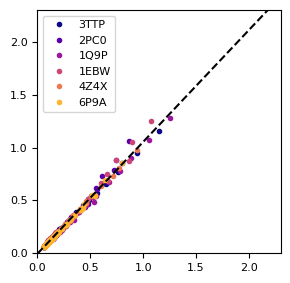

AFc


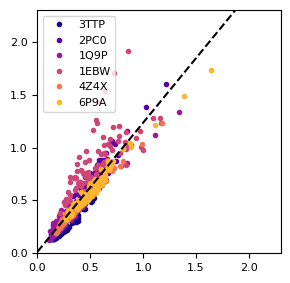

DiG


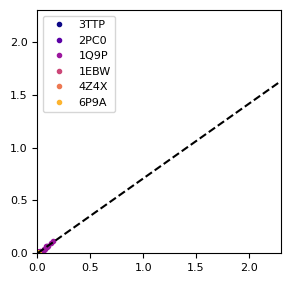

In [41]:
from scipy import stats

for jj, meth in enumerate(methods):
  print(meth)
  colors = plt.cm.plasma(np.linspace(0, 1, len(sys_names) + 1))
  plt.figure(figsize=(3,3))
  xv=[]
  yv=[]
  for ii,SYS in enumerate(sys_names):
    plt.plot(nodeepfake_data[SYS][meth]['rmsf'],data[SYS][meth]['rmsf'],'.',c=colors[ii],label=f"{SYS.upper()}")
    xv+=nodeepfake_data[SYS][meth]['rmsf'].tolist()
    yv+=data[SYS][meth]['rmsf'].tolist()


  xval=np.array(xv)
  yval=np.array(yv)

  xxx=np.linspace(0,5,10000)

  res1=stats.linregress(x=xval[:],y=yval[:])
  yyy1=res1.slope*xxx+res1.intercept
  plt.plot(xxx,yyy1,'--k')
  plt.ylim([0,2.3])
  plt.xlim([0,2.3])
  ax=plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc="upper left",fontsize=ticksize)
  plt.xticks(fontsize=ticksize)
  plt.yticks(fontsize=ticksize)
  plt.tight_layout()
  plt.show()
  plt.close()


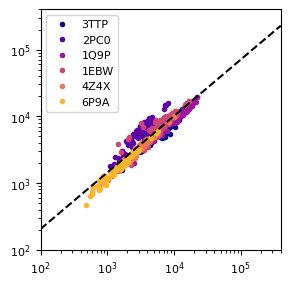


The slope is : 0.85


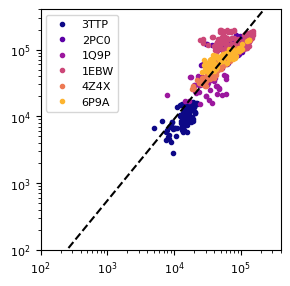


The slope is : 1.2


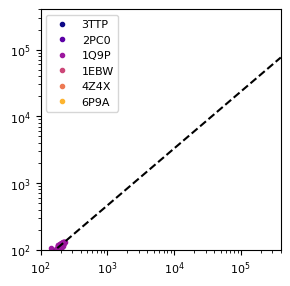


The slope is : 0.85


In [49]:
from scipy import stats

for jj, meth in enumerate(methods):
  colors = plt.cm.plasma(np.linspace(0, 1, len(sys_names) + 1))
  plt.figure(figsize=(3,3))
  xv=[]
  yv=[]
  for ii,SYS in enumerate(sys_names):
    plt.plot(nodeepfake_data[SYS][meth]['tau_avg'].T,data[SYS][meth]['tau_avg'].T,'.',c=colors[ii],label=f"{SYS.upper()}")
    xv+=nodeepfake_data[SYS][meth]['tau_avg'].T.tolist()
    yv+=data[SYS][meth]['tau_avg'].T.tolist()


  xval=np.array(xv)
  xval=np.log10(xval)
  yval=np.array(yv)
  yval=np.log10(yval)

  xxx=np.linspace(0,10,10000)

  res1=stats.linregress(x=xval[:],y=yval[:])
  yyy1=res1.slope*xxx+res1.intercept
  plt.plot(10**xxx,10**yyy1,'--k')
  plt.yscale('log')
  plt.xscale('log')
  plt.ylim([1e2,4e5])
  plt.xlim([1e2,4e5])
  ax=plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc="upper left",fontsize=ticksize)
  plt.xticks(fontsize=ticksize)
  plt.yticks(fontsize=ticksize)
  plt.tight_layout()
  plt.show()
  plt.close()
  print(f"\nThe slope is : {res1.slope:2.2}")

So slope<1 => it generally gets slower

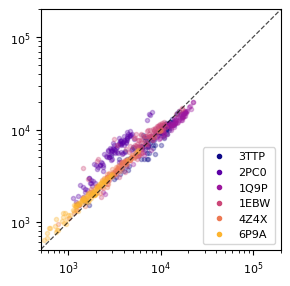

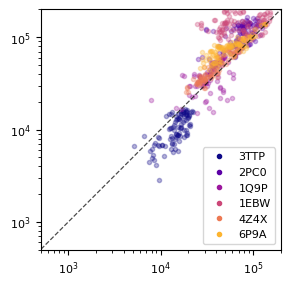

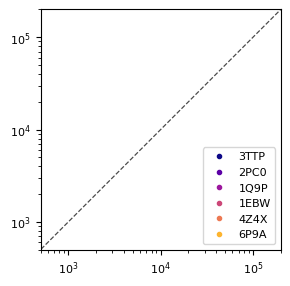

In [52]:
from scipy import stats

for jj, meth in enumerate(methods):
  colors = plt.cm.plasma(np.linspace(0, 1, len(sys_names) + 1))
  plt.figure(figsize=(3,3))
  xv=[]
  yv=[]
  for ii,SYS in enumerate(sys_names):
    plt.plot(nodeepfake_data[SYS][meth]['tau_avg'].T, data[SYS][meth]['tau_avg'].T, '.', markersize=6, alpha=0.3, c=colors[ii], label=f"{SYS.upper()}")

  xxx=np.linspace(0,1e6,10000)


  plt.plot(xxx,xxx,'--k',linewidth=0.9,alpha=0.7)
  plt.yscale('log')
  plt.xscale('log')
  plt.ylim([5e2,2e5])
  plt.xlim([5e2,2e5])
  ax=plt.gca()
  ax.set_aspect('equal')
  leg = plt.legend(loc="lower right",fontsize=ticksize)
  for ll in leg.legend_handles:
    ll.set_alpha(1)
  plt.xticks(fontsize=ticksize)
  plt.yticks(fontsize=ticksize)
  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/AF2_dynamics/figures/scatter_{meth}_all_tau_vals.png',dpi=600);
  #plt.savefig('fig5_all_tau_vals.png',dpi=600);
  plt.show()
  plt.close()
